## Building a CNN to classify images.


### รูปภาพที่ให้มามี 4 คลาส โดยมีหมายเลขคลาสดังนี้:
<ol start="0">
<li> frog
<li> cat
<li> dog
<li> horse
</ol>

In [82]:
import time, datetime
import requests, pickle
import numpy as np
from tensorflow import keras
from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
import random, os, tensorflow as tf

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # to Disable GPU training

In [84]:
print('Default GPU Device:', tf.test.gpu_device_name() or 'None')

Default GPU Device: /device:GPU:0


In [85]:
class_names = ['frog', 'cat', 'dog', 'horse']

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(open('364_midterm_data.pkl', "rb"))

# url = "https://drive.google.com/uc?id=1v6wfLWvOzq2Aaw7MuhnkZd1VRCgLTh4b"
# (X_train, y_train, X_val, y_val, X_test, y_test) = pickle.loads(requests.get(url).content)

### ดูรูปภาพในชุดข้อมูล

In [86]:
def show_images(X, y, class_names, n_rows=3, n_cols=8, figsize=(9, 4)):
    fig = plt.figure(figsize=figsize)
    for i in range(0, n_rows):
        for j in range(0, n_cols):
            idx = i*n_cols + j
            image = X[idx]
            label = class_names[y[idx][0]]        
            ax = plt.subplot(n_rows, n_cols, idx+1)
            plt.imshow(image)
            plt.text(16, 36, str(y[idx]) + ' - ' + label, ha='center')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

[0] frog


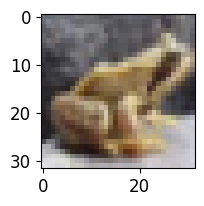

In [87]:
print(y_test[1], class_names[y_test[1][0]])
plt.figure(figsize=(2, 2))
plt.imshow(X_test[1])

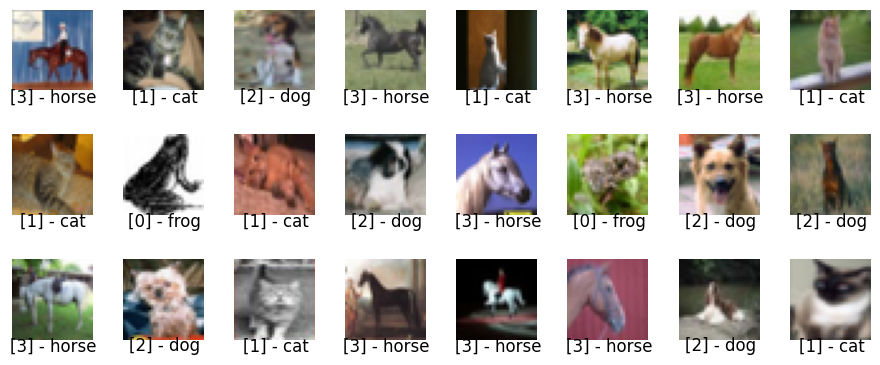

In [88]:
show_images(X_train, y_train, class_names, 3, 8)

### Normalize images and One-Hot Encode labels

In [89]:
n_classes = len(class_names)

y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [90]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

<style> h3 { margin-top: 0.5em !important; margin-bottom: 0.0em; }
        h4 { margin-top: 0.1em !important; margin-bottom: 0.1em; }
        h5 { margin-top: 0.0em; margin-bottom: 0.2em; } </style>

# <span style="color:blue">โจทย์คำถาม</span>
* ### เพื่อป้องกันผลกระทบจาก randomness ให้นิสิตใช้ค่า seed เป็น 12345 ในทุกกรณีที่เกี่ยวข้องกับการสุ่ม และให้เรียกใช้ฟังก์ชัน set_seed(12345) ทุกครั้งก่อนที่จะสร้างโมเดล
* ### ให้สร้างโมเดลด้วย CNN เพื่อให้ได้ accuracy ที่ดีที่สุด และห้ามใช้ Early Stopping หรือใช้ Best Weights ในการเทรนโมเดล โดยให้เทรนโมเดลเต็มจำนวน epoch ที่นิสิตกำหนด โดยค่า epoch ต้องไม่น้อยกว่า 50 และต้องหารด้วย 20 ลงตัว
  * #### (10 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.65
  * #### (15 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.70
  * #### (20 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.73
  * #### (25 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.75
  * #### (30 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.80
  * #### (35 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.83
  * #### (40 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.85
  * #### (50 คะแนน) ค่า accuracy จากข้อมูลเทสไม่น้อยกว่า 0.90  
* ### (25 คะแนน) ให้แสดงกราฟ Loss และ Accuracy ของโมเดลที่เกิดจากการเทรนโมเดล และหลังจากโมเดลถูกเทรนแล้วเสร็จ ให้แสดงค่า Accuracy ที่วัดได้จากชุดข้อมูล train, validation และ test
* ### (25 คะแนน) ให้แสดง Confusion Matrix ผลการทำนายที่ได้จากโมเดลด้วยข้อมูลเทส
  ##### บอกใบ้ จากโค้ดข้างล่าง ค่าข้อมูลแต่ละตัวใน y_pred (ที่ได้จาก model.predict(...)) และ y_test จะมี 4 จำนวน (ตามจำนวนคลาส) โดยใน y_pred จะเก็บค่าความน่าจะเป็นที่อินพุต X_test จะเป็นแต่ละคลาส เช่น [0.6, 0.05, 0.15, 0.2] ซึ่งหมายถึง ความน่าจะเป็นที่อินพุตจะเป็นคลาส 0 มีค่าเป็น 0.6 และในลักษณะเดียวกัน y_test จะเก็บค่าผลเฉลยซึ่งอยู่ในรูป One-Hot Encoding เช่น [0, 0, 0, 1] ซึ่งหมายถึง ผลเฉลยของอินพุตเป็นคลาส 3 เป็นต้น เราใช้ np.argmax(...) เพื่อแปลงค่าที่อยู่ในรูปเวกเตอร์ให้กลายเป็นค่าสเกลาร์ เพื่อความสะดวกในการเปรียบเทียบระหว่างผลทำนายกับผลเฉลย
    ```python
    y_pred = model.predict(X_test, verbose=0)
    y_test_1d = np.argmax(y_test, axis=1
    y_pred_1d = np.argmax(y_pred, axis=1)
    ```
  ##### ในโมดูล sklearn ภายใต้ metrics มีฟังก์ชัน confusion_matrix(...) ที่ใช้คำนวณ Confusion Matrix<br>
* ### (25 คะแนน) ให้คำนวณค่า Recall ของแต่ละคลาสด้วยข้อมูลเทส โดยให้เขียนตอบในรูปนิพจน์ตามตัวอย่างด้านล่าง ซึ่งค่า Recall บ่งบอกถึงความสามารถของโมเดลในการทำนายคลาสที่สนใจได้อย่างถูกต้อง โดยโมเดลที่มีค่า Recall สูงบ่งบอกถึงโมเดลสามารถทำนายคลาสที่สนใจได้ถูกต้องเป็นจำนวนมาก ค่า Recall คำนวณได้จากสูตรข้างล่างนี้ <br><br> $$ Recall = {TruePositives \over TruePositives + FalseNegatives} $$ 
### จากตัวอย่างในตาราง Confusion Matrix ด้านล่างนี้ ค่า Recall ของคลาส Apple คำนวณได้จาก 7 / (7 + 1 + 3) = 0.6364 ส่วนของคลาส Orange คำนวณได้จาก 2 / (2 + 8 + 2) = 0.1667 และของคลาส Mango คำนวณได้จาก 1 / (1 + 9 + 3) = 0.0769

 <center><img src="https://drive.google.com/thumbnail?id=1v8N__pdOnfAV-JwBR4rfKJdTSqOSeAv4&sz=w500"></center>

* ### (โบนัส 20 คะแนน) จงเปรียบเทียบและอธิบายค่า Recall ที่คำนวณได้จากทั้ง 4 คลาส และให้แสดงภาพจำนวน 5 ภาพที่มาจากคลาสที่มีค่า Recall สูงสุดแต่โมเดลทำนายผิด โดยให้แสดงค่าคลาสของแต่ละภาพที่โมเดลทำนายออกมาด้วย

In [91]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib.ticker import MaxNLocator

In [92]:
seed = 12345
set_seed(seed)

batch_size = 32
model = Sequential()

model.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                 input_shape=X_train.shape[1:], activation='relu'))

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.00075),
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 32, 32, 32)        2432      
                                                                 
 conv2d_115 (Conv2D)         (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_116 (Conv2D)         (None, 14, 14, 32)        25632     
                                                                 
 conv2d_117 (Conv2D)         (None, 10, 10, 32)        25632     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                

In [93]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/50


600/600 [==============================] - 6s 8ms/step - loss: 1.1025 - accuracy: 0.5052 - val_loss: 0.9253 - val_accuracy: 0.5996
Epoch 2/50
600/600 [==============================] - 5s 8ms/step - loss: 0.8761 - accuracy: 0.6290 - val_loss: 0.8165 - val_accuracy: 0.6446
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 0.7684 - accuracy: 0.6821 - val_loss: 0.7327 - val_accuracy: 0.6896
Epoch 4/50
600/600 [==============================] - 4s 7ms/step - loss: 0.6892 - accuracy: 0.7171 - val_loss: 0.7077 - val_accuracy: 0.7088
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 0.6178 - accuracy: 0.7486 - val_loss: 0.6515 - val_accuracy: 0.7304
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 0.5521 - accuracy: 0.7778 - val_loss: 0.6528 - val_accuracy: 0.7321
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 0.5049 - accuracy: 0.8016 - val_loss: 0.6372 - val_accuracy: 0.7421
Epoch 8/50
600/60

แสดง กราฟ Loss

Train Loss: 0.021682, Accuracy: 0.993906
 Test Loss: 1.742098, Accuracy: 0.750000


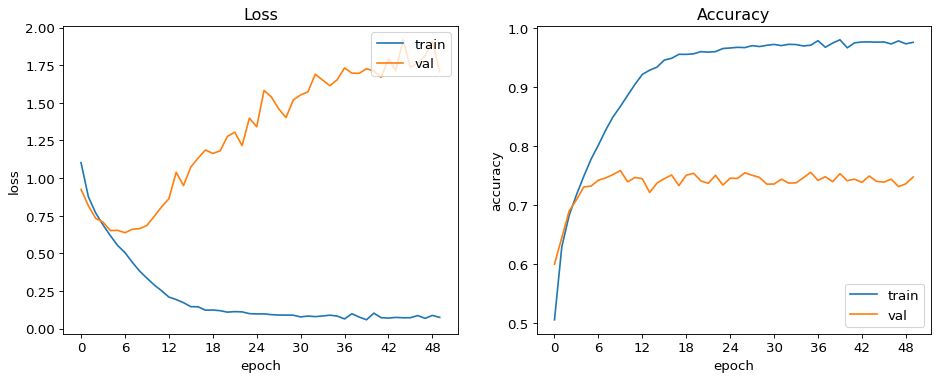

In [94]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(X_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(X_test, y_test, verbose=0)))

Confusion Matrix

In [95]:
y_pred = model.predict(X_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

[[542  82  34  20]
 [ 33 355 130  33]
 [ 10 113 392  36]
 [ 15  50  44 511]]


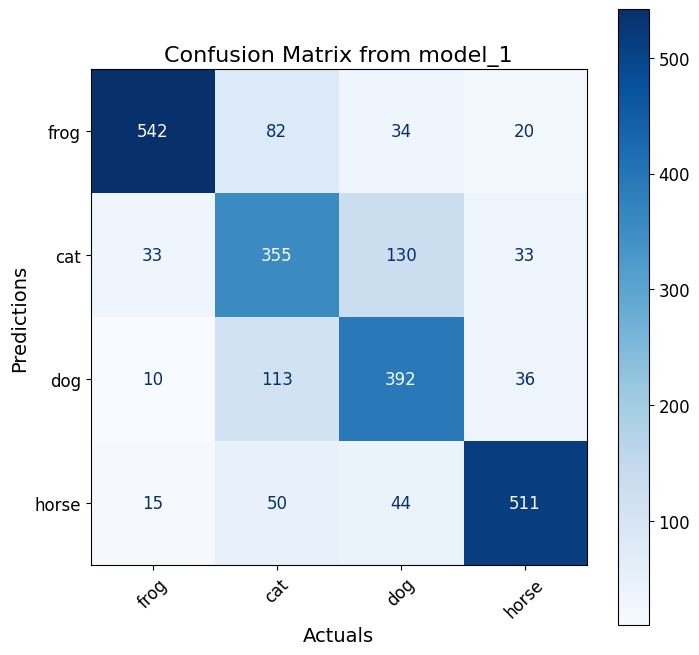

In [96]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

Recall Calculation

In [97]:
# Recall = TP / (TP + FN)
# Print the recall for each class

recall_frog = cm[0][0] / (cm[0][0] + cm[1][0] + cm[2][0] + cm[3][0])

print ("Recall for frog = {:d} / ({:d} + {:d} + {:d} + {:d}) = {:.4f}".format(cm[0][0], cm[0][0], cm[1][0], cm[2][0], cm[3][0], recall_frog))

recall_cat = cm[1][1] / (cm[0][1] + cm[1][1] + cm[2][1] + cm[3][1])

print ("Recall for cat = {:d} / ({:d} + {:d} + {:d} + {:d}) = {:.4f}".format(cm[1][1], cm[0][1], cm[1][1], cm[2][1], cm[3][1], recall_cat))

recall_dog = cm[2][2] / (cm[0][2] + cm[1][2] + cm[2][2] + cm[3][2])

print ("Recall for dog = {:d} / ({:d} + {:d} + {:d} + {:d}) = {:.4f}".format(cm[2][2], cm[0][2], cm[1][2], cm[2][2], cm[3][2], recall_dog))

recall_horse = cm[3][3] / (cm[0][3] + cm[1][3] + cm[2][3] + cm[3][3])

print ("Recall for horse = {:d} / ({:d} + {:d} + {:d} + {:d}) = {:.4f}".format(cm[3][3], cm[0][3], cm[1][3], cm[2][3], cm[3][3], recall_horse))

Recall for frog = 542 / (542 + 33 + 10 + 15) = 0.9033
Recall for cat = 355 / (82 + 355 + 113 + 50) = 0.5917
Recall for dog = 392 / (34 + 130 + 392 + 44) = 0.6533
Recall for horse = 511 / (20 + 33 + 36 + 511) = 0.8517


Actual: cat, Pred: dog


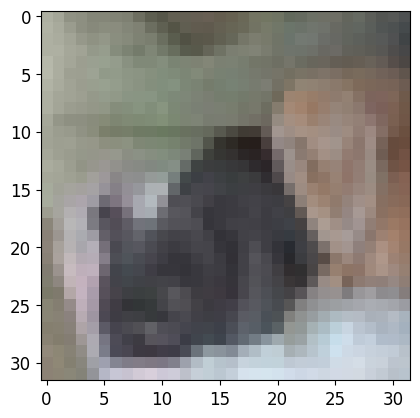

Actual: cat, Pred: dog


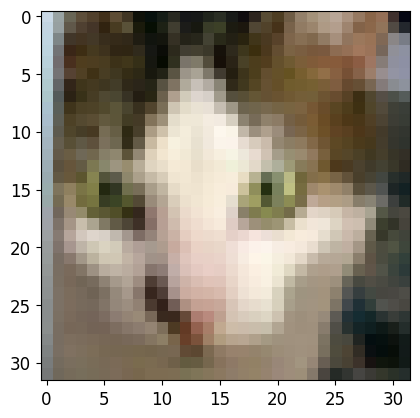

Actual: cat, Pred: horse


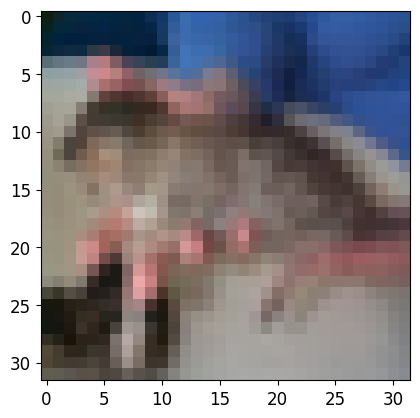

Actual: horse, Pred: dog


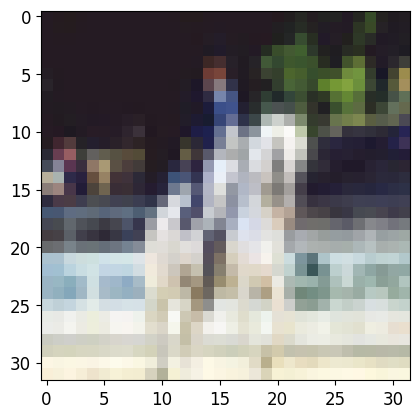

Actual: horse, Pred: cat


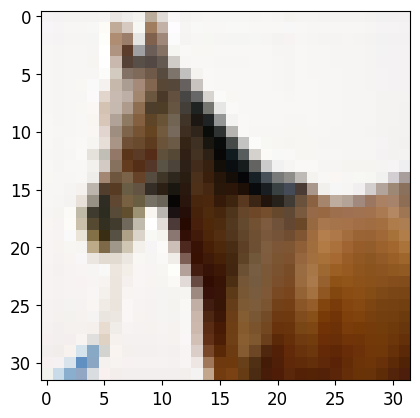

In [98]:
# Show 5 incorrect prediction for highest recall class
# Show Actual and Predicted class names

incorrect = np.nonzero(y_pred_1d != y_test_1d)[0]
for i in range(0, 5):
    idx = incorrect[i]
    print('Actual: {:s}, Pred: {:s}'.format(class_names[y_test_1d[idx]], class_names[y_pred_1d[idx]]))
    plt.imshow(X_test[idx])
    plt.show()